In [2]:
# İmports
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import optuna

# Loading datasets
train = pd.read_csv("/kaggle/input/playground-series-s5e6/train.csv", index_col="id")
test = pd.read_csv("/kaggle/input/playground-series-s5e6/test.csv", index_col="id")
original = pd.read_csv("/kaggle/input/fertilizer-prediction/Fertilizer Prediction.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s5e6/sample_submission.csv")

print(
    f"train shape: {train.shape}\ntest shape: {test.shape}\noriginal shape: {original.shape}\nsubmission shape: {submission.shape}"
)

train shape: (750000, 9)
test shape: (250000, 8)
original shape: (100000, 9)
submission shape: (250000, 2)


# 📊 Data Analysis & Visualization

In [3]:
display(original.head(3))
display(train.head(3))
display(test.head(3))

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,32,51,41,Red,Ground Nuts,7,3,19,14-35-14
1,35,58,35,Black,Cotton,4,14,16,Urea
2,27,55,43,Sandy,Sugarcane,28,0,17,20-20


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
id,,,,,,,,
750000,31,70,52,Sandy,Wheat,34,11,24
750001,27,62,45,Red,Sugarcane,30,14,15
750002,28,72,28,Clayey,Ground Nuts,14,15,4


In [4]:
# Rename the 'Temparature' column to 'Temperature'
def rename_temperature_column(df):
    df = df.rename(columns={"Temparature": "Temperature"})
    print("Column name corrected from 'Temparature' to 'Temperature'")
    return df

train = rename_temperature_column(train)
test = rename_temperature_column(test)
original = rename_temperature_column(original)

Column name corrected from 'Temparature' to 'Temperature'
Column name corrected from 'Temparature' to 'Temperature'
Column name corrected from 'Temparature' to 'Temperature'


In [5]:
# Analyse values, unique counts, and NaNs
def analyse_data(df,cols):
    d = pd.DataFrame()
    cl = [];u = [];s =[]; nans =[];share=[]
    for c in cols:
        cl.append(c); u.append(df[c].unique());s.append(df[c].unique().size);nans.append(df[c].isnull().sum());share.append(round((df[c].isnull().sum()/len(df))*100,2))
    d['Column'] = cl;d["Uniques"] = u; d["Frequency"] = s; d["Nans"] = nans; d["ShareOfNans"]= share
    return d

print("#" * 50, "Original", "#" * 50)
display(analyse_data(original,original.columns))
print("#" * 50, "Train", "#" * 50)
display(analyse_data(train,train.columns))
print("#" * 50, "Test", "#" * 50)
display(analyse_data(test,test.columns))

################################################## Original ##################################################


,Column,Uniques,Frequency,Nans,ShareOfNans
0,Temperature,"[32, 35, 27, 33, 37, 28, 30, 36, 29, 38, 25, 3...",14,0,0.0
1,Humidity,"[51, 58, 55, 56, 70, 68, 71, 52, 65, 63, 57, 6...",23,0,0.0
2,Moisture,"[41, 35, 43, 56, 60, 25, 28, 34, 42, 45, 40, 2...",41,0,0.0
3,Soil Type,"[Red, Black, Sandy, Loamy, Clayey]",5,0,0.0
4,Crop Type,"[Ground Nuts, Cotton, Sugarcane, Wheat, Tobacc...",11,0,0.0
5,Nitrogen,"[7, 4, 28, 37, 33, 21, 31, 26, 9, 19, 5, 32, 2...",39,0,0.0
6,Potassium,"[3, 14, 0, 5, 6, 19, 4, 17, 2, 8, 16, 11, 10, ...",20,0,0.0
7,Phosphorous,"[19, 16, 17, 24, 9, 13, 0, 6, 36, 20, 33, 7, 2...",43,0,0.0
8,Fertilizer Name,"[14-35-14, Urea, 20-20, 28-28, 10-26-26, DAP, ...",7,0,0.0


################################################## Train ##################################################


,Column,Uniques,Frequency,Nans,ShareOfNans
0,Temperature,"[37, 27, 29, 35, 30, 36, 28, 32, 38, 26, 34, 2...",14,0,0.0
1,Humidity,"[70, 69, 63, 62, 58, 59, 51, 50, 61, 60, 57, 7...",23,0,0.0
2,Moisture,"[36, 65, 32, 54, 43, 29, 53, 44, 35, 60, 27, 4...",41,0,0.0
3,Soil Type,"[Clayey, Sandy, Red, Loamy, Black]",5,0,0.0
4,Crop Type,"[Sugarcane, Millets, Barley, Paddy, Pulses, To...",11,0,0.0
5,Nitrogen,"[36, 30, 24, 39, 37, 10, 26, 19, 25, 18, 34, 4...",39,0,0.0
6,Potassium,"[4, 6, 12, 2, 0, 15, 17, 3, 19, 16, 1, 13, 7, ...",20,0,0.0
7,Phosphorous,"[5, 18, 16, 4, 9, 22, 35, 29, 2, 12, 19, 39, 3...",43,0,0.0
8,Fertilizer Name,"[28-28, 17-17-17, 10-26-26, DAP, 20-20, 14-35-...",7,0,0.0


################################################## Test ##################################################


,Column,Uniques,Frequency,Nans,ShareOfNans
0,Temperature,"[31, 27, 28, 37, 35, 38, 25, 29, 26, 33, 30, 3...",14,0,0.0
1,Humidity,"[70, 62, 72, 53, 55, 63, 50, 56, 71, 60, 64, 5...",23,0,0.0
2,Moisture,"[52, 45, 28, 57, 32, 34, 56, 44, 60, 40, 61, 5...",41,0,0.0
3,Soil Type,"[Sandy, Red, Clayey, Black, Loamy]",5,0,0.0
4,Crop Type,"[Wheat, Sugarcane, Ground Nuts, Pulses, Millet...",11,0,0.0
5,Nitrogen,"[34, 30, 14, 18, 13, 36, 32, 26, 9, 23, 8, 6, ...",39,0,0.0
6,Potassium,"[11, 14, 15, 17, 19, 3, 6, 9, 5, 4, 16, 0, 10,...",20,0,0.0
7,Phosphorous,"[24, 15, 4, 36, 14, 2, 31, 32, 13, 41, 40, 27,...",43,0,0.0


In [6]:
print("#" * 50, "Original", "#" * 50)
display(original.describe().T)
print("#" * 50, "Train", "#" * 50)
display(train.describe().T)
print("#" * 50, "Test", "#" * 50)
display(test.describe().T)

################################################## Original ##################################################


,count,mean,std,min,25%,50%,75%,max
Temperature,100000.0,31.50330,4.019942,25.0,28.0,32.0,35.0,38.0
Humidity,100000.0,60.98581,6.651393,50.0,55.0,61.0,67.0,72.0
Moisture,100000.0,45.00344,11.838710,25.0,35.0,45.0,55.0,65.0
Nitrogen,100000.0,22.98677,11.247289,4.0,13.0,23.0,33.0,42.0
Potassium,100000.0,9.47222,5.768565,0.0,4.0,9.0,14.0,19.0
Phosphorous,100000.0,21.01348,12.391180,0.0,10.0,21.0,32.0,42.0


################################################## Train ##################################################


,count,mean,std,min,25%,50%,75%,max
Temperature,750000.0,31.503565,4.025574,25.0,28.0,32.0,35.0,38.0
Humidity,750000.0,61.038912,6.647695,50.0,55.0,61.0,67.0,72.0
Moisture,750000.0,45.184147,11.794594,25.0,35.0,45.0,55.0,65.0
Nitrogen,750000.0,23.093808,11.216125,4.0,13.0,23.0,33.0,42.0
Potassium,750000.0,9.478296,5.765622,0.0,4.0,9.0,14.0,19.0
Phosphorous,750000.0,21.073227,12.346831,0.0,10.0,21.0,32.0,42.0


################################################## Test ##################################################


,count,mean,std,min,25%,50%,75%,max
Temperature,250000.0,31.491648,4.024093,25.0,28.0,31.0,35.0,38.0
Humidity,250000.0,61.045120,6.636372,50.0,55.0,61.0,67.0,72.0
Moisture,250000.0,45.190444,11.793167,25.0,35.0,45.0,55.0,65.0
Nitrogen,250000.0,23.139612,11.215956,4.0,13.0,23.0,33.0,42.0
Potassium,250000.0,9.487764,5.766860,0.0,4.0,10.0,14.0,19.0
Phosphorous,250000.0,21.122060,12.380870,0.0,10.0,21.0,32.0,42.0


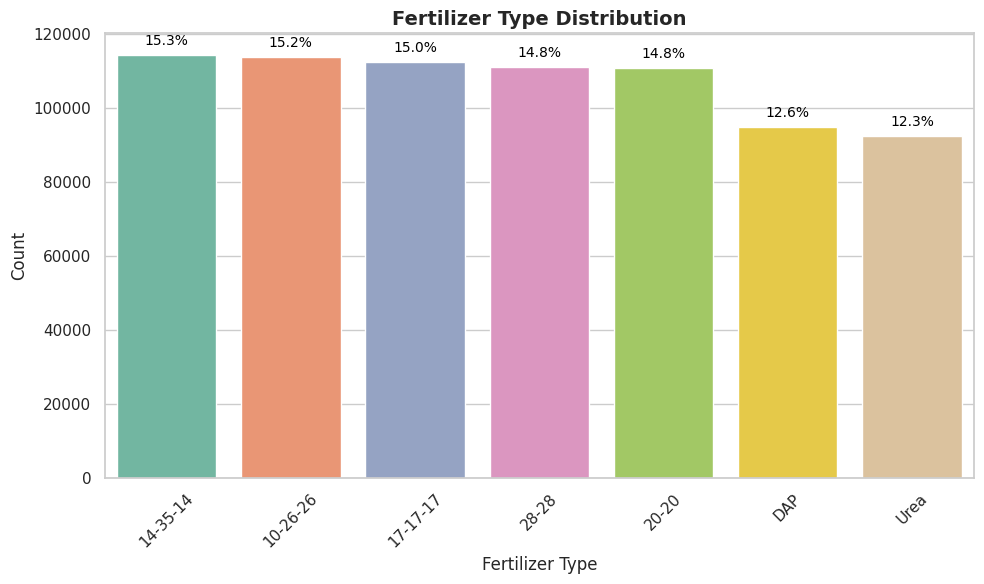

In [7]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.countplot(
    data=train, 
    x='Fertilizer Name', 
    order=train['Fertilizer Name'].value_counts().index,
    palette='Set2'
)

plt.title('Fertilizer Type Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Fertilizer Type')
plt.ylabel('Count')
plt.xticks(rotation=45)

total = len(train)
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.annotate(
        percentage, 
        (p.get_x() + p.get_width() / 2., height), 
        ha='center', va='bottom', 
        xytext=(0, 5), textcoords='offset points',
        fontsize=10, color='black'
    )

plt.tight_layout()
plt.show()


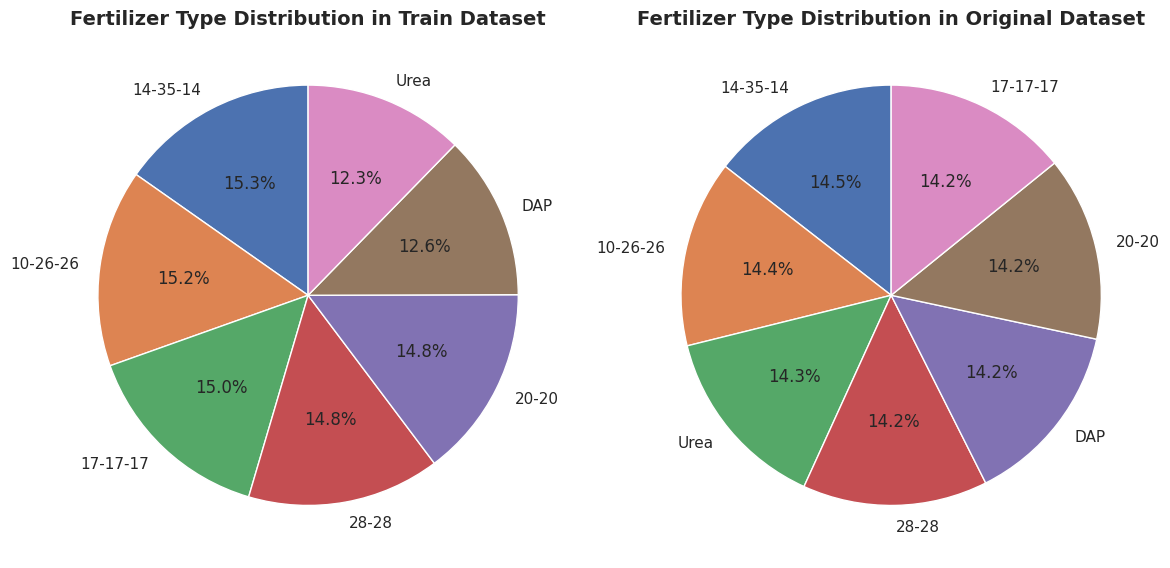

In [8]:
# Visualize the distribution of Fertilizer Type

plt.figure(figsize=(12, 6))

# train dataset
plt.subplot(1, 2, 1)
fertilizer_counts = train['Fertilizer Name'].value_counts()
plt.pie(fertilizer_counts.values,
        labels=fertilizer_counts.index,
        autopct='%1.1f%%',
        startangle=90)
plt.title('Fertilizer Type Distribution in Train Dataset', fontsize=14, fontweight='bold')

# original dataset
plt.subplot(1, 2, 2)
original_fertilizer_counts = original['Fertilizer Name'].value_counts()
plt.pie(original_fertilizer_counts.values,
        labels=original_fertilizer_counts.index,
        autopct='%1.1f%%',
        startangle=90)
plt.title('Fertilizer Type Distribution in Original Dataset', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

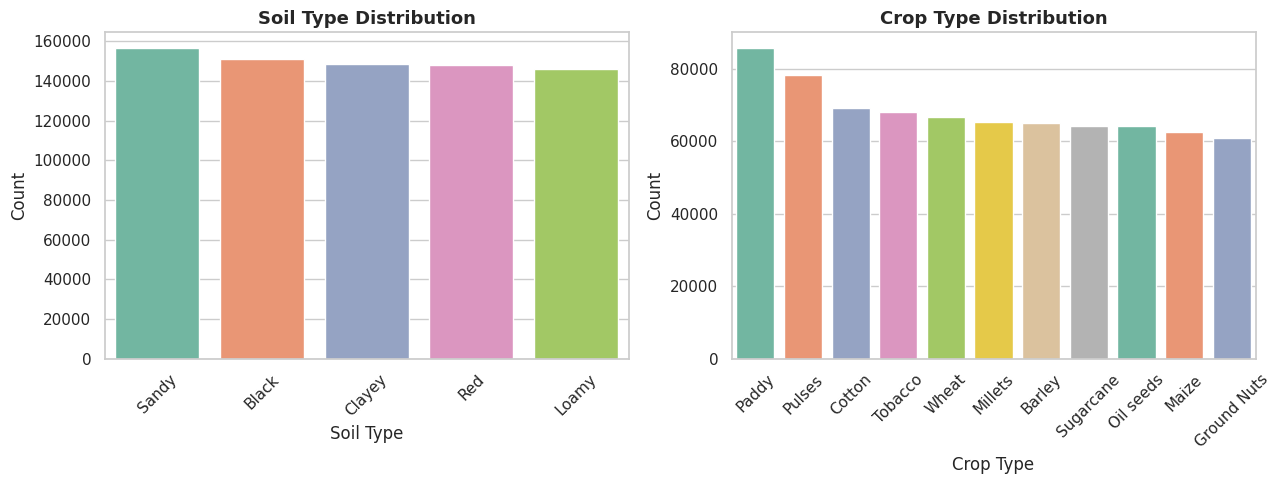

In [9]:
# Categorical columns distribution visualization

categorical_cols = ['Soil Type', 'Crop Type']

plt.figure(figsize=(13, 5))

for i, col in enumerate(categorical_cols):
    plt.subplot(1, len(categorical_cols), i + 1)
    sns.countplot(
        data=train, 
        x=col, 
        order=train[col].value_counts().index, 
        palette='Set2'
    )
    
    plt.title(f'{col} Distribution', fontsize=13, fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

STATISTICS FOR NUMERICAL COLUMNS:


,Temperature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


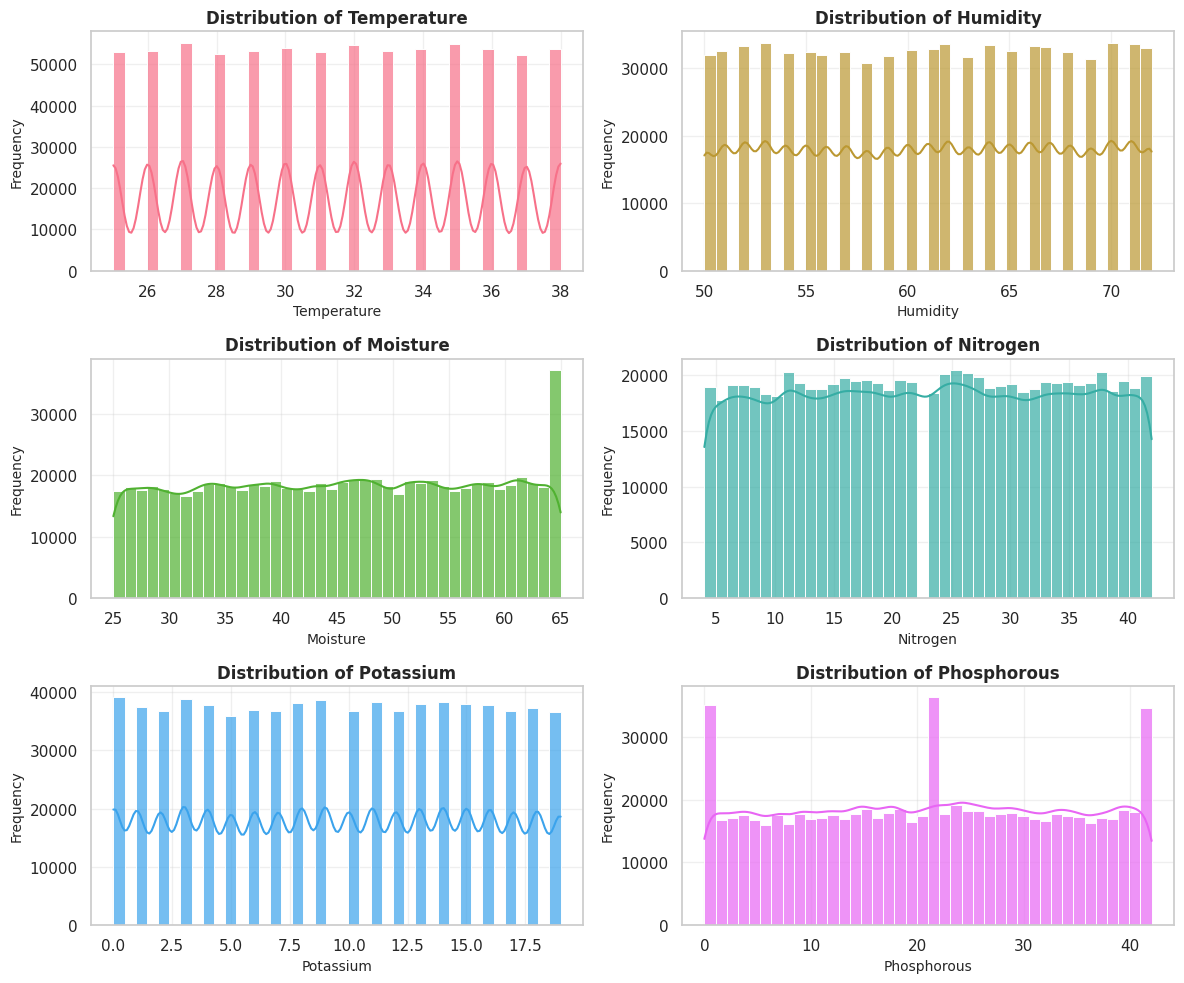

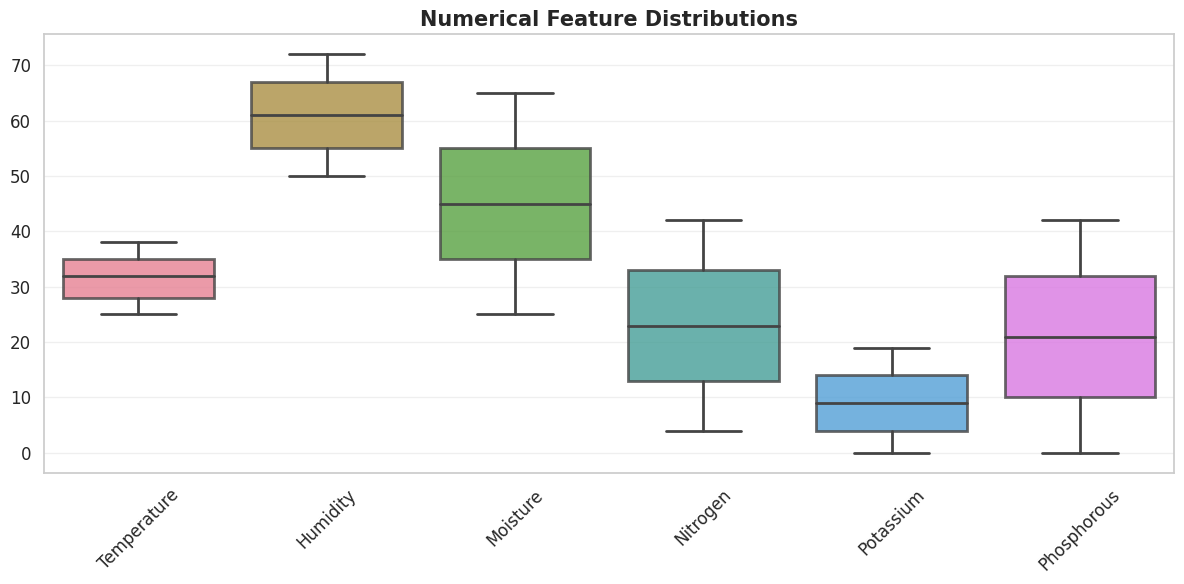

In [10]:
# Numerical columns distribution visualization
warnings.filterwarnings('ignore', category=FutureWarning)

numerical_cols = ['Temperature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

print("STATISTICS FOR NUMERICAL COLUMNS:")
display(train[numerical_cols].describe())
palette = sns.color_palette("husl", len(numerical_cols))

# Histogram plots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    sns.histplot(
        data=train, 
        x=col, 
        bins=40, 
        kde=True, 
        color=palette[i], 
        ax=axes[i], 
        alpha=0.7
    )
    axes[i].set_title(f'Distribution of {col}', fontweight='bold', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
sns.boxplot(
    data=train[numerical_cols], 
    palette=palette, 
    linewidth=2, 
    fliersize=4, 
    boxprops=dict(alpha=.8)
)
plt.title('Numerical Feature Distributions', fontsize=15, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

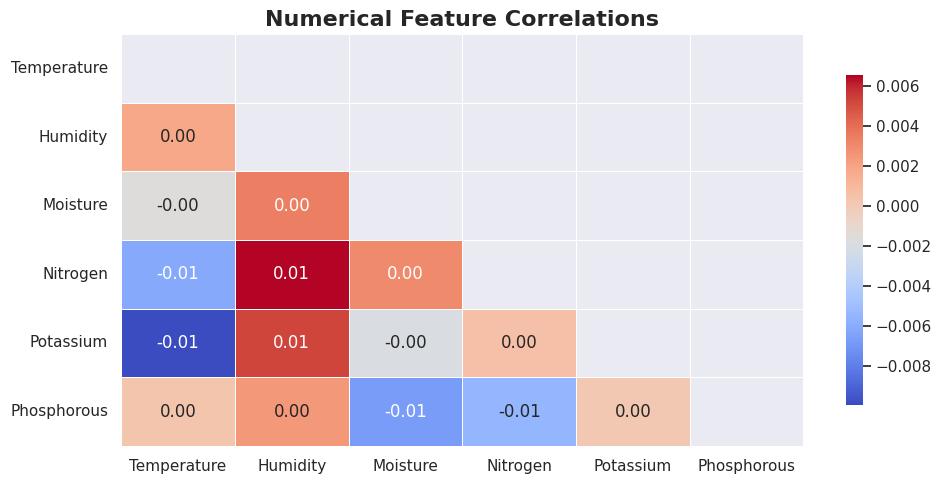

In [11]:
# Numerical correlation heatmap
sns.set_theme(style="dark")
fig, ax = plt.subplots(figsize=(10, 5))
corr_matrix = train[numerical_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='coolwarm', 
    mask=mask, 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8},
    ax=ax
)
ax.set_title('Numerical Feature Correlations', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 🛠️ Feature Engineering

In [12]:
# Data Augmentation
original_copy = original.copy()
for k in range(4):
    original = pd.concat([original,original_copy],axis=0)

print(original.shape)

(500000, 9)


In [13]:
# Please use with care: converts numeric values to string categories.

def add_binned_features(df):
    for col in ['Temperature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']:
        df[f'{col}_Binned'] = df[col].astype(str).astype('category')
    return df

train = add_binned_features(train)
test = add_binned_features(test)
original = add_binned_features(original)

original.head()

,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,Temperature_Binned,Humidity_Binned,Moisture_Binned,Nitrogen_Binned,Potassium_Binned,Phosphorous_Binned
0,32,51,41,Red,Ground Nuts,7,3,19,14-35-14,32,51,41,7,3,19
1,35,58,35,Black,Cotton,4,14,16,Urea,35,58,35,4,14,16
2,27,55,43,Sandy,Sugarcane,28,0,17,20-20,27,55,43,28,0,17
3,33,56,56,Loamy,Ground Nuts,37,5,24,28-28,33,56,56,37,5,24
4,32,70,60,Red,Ground Nuts,4,6,9,14-35-14,32,70,60,4,6,9


In [14]:
cat_cols = [col for col in train.select_dtypes(include=['object', 'category']).columns 
            if col != "Fertilizer Name"]

# Encoding
for i in cat_cols:
    label_enc = LabelEncoder()
    train[i] = label_enc.fit_transform(train[i])
    original[i] = label_enc.fit_transform(original[i])
    test[i] = label_enc.transform(test[i])

fer_label_enc = LabelEncoder()
train["Fertilizer Name"] = fer_label_enc.fit_transform(train["Fertilizer Name"])
original["Fertilizer Name"] = fer_label_enc.fit_transform(original["Fertilizer Name"])
for col in cat_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")
    original[col] = original[col].astype("category")

# Dataset
X = train.drop(columns=["Fertilizer Name"])
y = train["Fertilizer Name"]
X_test = test

X_original = original.drop(columns=["Fertilizer Name"])
y_original = original["Fertilizer Name"]

# 🤖 Modeling & Optimization

In [15]:
# Function to calculate Mean Average Precision at k (MAP@k)
def mapk(actual, predicted, k=3):
    def apk(a, p, k):
        p = p[:k]
        score = 0.0
        hits = 0
        seen = set()
        for i, pred in enumerate(p):
            if pred in a and pred not in seen:
                hits += 1
                score += hits / (i + 1.0)
                seen.add(pred)
        return score / min(len(a), k)
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [16]:
"""from catboost import CatBoostClassifier


cat_features_names = X.select_dtypes(include=['category']).columns.tolist()

BASE_PARAMS = {
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass',
    'task_type': 'GPU',
    'random_seed': 42,
}

def objective(trial):
    search_params = {
        'iterations': trial.suggest_int('iterations', 500, 6000),
        'depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'border_count': trial.suggest_int('border_count', 32, 255),
    }
    params = {**BASE_PARAMS, **search_params}

    FOLDS = 3
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
    map3_scores = []

    for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        x_train = pd.concat([x_train, X_original], axis=0, ignore_index=True)
        y_train = pd.concat([y_train, y_original], axis=0, ignore_index=True)

        model = CatBoostClassifier(**params)

        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            cat_features=cat_features_names,
            early_stopping_rounds=50,
            verbose=200
        )

        oof_preds_proba = model.predict_proba(x_valid)
        top_3_preds = np.argsort(oof_preds_proba, axis=1)[:, -3:][:, ::-1]  
        actual = [[label] for label in y_valid]
        map3_score = mapk(actual, top_3_preds)
        map3_scores.append(map3_score)

    avg_map3 = np.mean(map3_scores)
    
    return avg_map3

study = optuna.create_study(
    direction="maximize", 
    study_name="catboost_fertilizer_optimization"
)

study.optimize(
    objective, 
    n_trials = 7,
    show_progress_bar=True, 
    gc_after_trial=True
)

print("\n\n" + "="*50)

print(f"  MAP@3 Score: {study.best_value:.5f}")
print("  Best Parameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")
print("="*50 + "\n")

best_params = study.best_params"""

'from catboost import CatBoostClassifier\n\n\ncat_features_names = X.select_dtypes(include=[\'category\']).columns.tolist()\n\nBASE_PARAMS = {\n    \'loss_function\': \'MultiClass\',\n    \'eval_metric\': \'MultiClass\',\n    \'task_type\': \'GPU\',\n    \'random_seed\': 42,\n}\n\ndef objective(trial):\n    search_params = {\n        \'iterations\': trial.suggest_int(\'iterations\', 500, 6000),\n        \'depth\': trial.suggest_int(\'depth\', 4, 12),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.1, log=True),\n        \'l2_leaf_reg\': trial.suggest_float(\'l2_leaf_reg\', 1e-3, 10.0, log=True),\n        \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 1, 100),\n        \'border_count\': trial.suggest_int(\'border_count\', 32, 255),\n    }\n    params = {**BASE_PARAMS, **search_params}\n\n    FOLDS = 3\n    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)\n    \n    map3_scores = []\n\n    for i, (train_idx, valid_idx) in en

In [17]:
"""import xgboost as xgb

BASE_PARAMS = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y)),
    'eval_metric': 'mlogloss',
    'tree_method': 'hist',
    'device': "cuda",
    'random_state': 42,
}

def objective(trial):
    search_params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.05, log=True),
        'max_bin': trial.suggest_int('max_bin', 128, 512),
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 5.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
    }
    
    params = {**BASE_PARAMS, **search_params}

    FOLDS = 3
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
    map3_scores = []

    for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        x_train = pd.concat([x_train, X_original], axis=0, ignore_index=True)
        y_train = pd.concat([y_train, y_original], axis=0, ignore_index=True)
        
        dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
        dvalid = xgb.DMatrix(x_valid, label=y_valid, enable_categorical=True)
        
        early_stopping_callback = xgb.callback.EarlyStopping(
            rounds=50,
            save_best=True,
        )
        callbacks = [early_stopping_callback]

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=10000,
            evals=[(dvalid, 'valid')],
            callbacks=callbacks,
            verbose_eval=100,
        )
        
        oof_preds_proba = model.predict(dvalid, iteration_range=(0, model.best_iteration))
        
        top_3_preds = np.argsort(oof_preds_proba, axis=1)[:, -3:][:, ::-1]  
        actual = [[label] for label in y_valid]
        map3_score = mapk(actual, top_3_preds)
        map3_scores.append(map3_score)

    avg_map3 = np.mean(map3_scores)
    
    return avg_map3

study = optuna.create_study(
    direction="maximize", 
    study_name="xgb_fertilizer_pruning_optimization"
)

study.optimize(
    objective, 
    n_trials = 3, 
    show_progress_bar=True, 
    gc_after_trial=True
)

print("\n\n" + "="*50)

print(f"  MAP@3 Score: {study.best_value:.5f}")
print("  Best Parameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")
print("="*50 + "\n")

best_params = study.best_params"""

'import xgboost as xgb\n\nBASE_PARAMS = {\n    \'objective\': \'multi:softprob\',\n    \'num_class\': len(np.unique(y)),\n    \'eval_metric\': \'mlogloss\',\n    \'tree_method\': \'hist\',\n    \'device\': "cuda",\n    \'random_state\': 42,\n}\n\ndef objective(trial):\n    search_params = {\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 12),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.008, 0.05, log=True),\n        \'max_bin\': trial.suggest_int(\'max_bin\', 128, 512),\n        \'lambda\': trial.suggest_float(\'lambda\', 1e-8, 10.0, log=True),\n        \'alpha\': trial.suggest_float(\'alpha\', 1e-8, 10.0, log=True),\n        \'gamma\': trial.suggest_float(\'gamma\', 1e-8, 5.0, log=True),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 100),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.5, 1.0),\n        \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.3, 1.0),\n        \'colsample_bylevel\':

In [18]:
xgb_params = {
        'objective': 'multi:softprob',  
        'num_class': len(np.unique(y)), 
        'max_depth': 7,
        'learning_rate': 0.036,
        'subsample': 0.8268755274662012,
        'max_bin': 369,
    "min_child_weight": 76,
        'colsample_bytree': 0.47583064834887157, 
        'colsample_bylevel': 0.5430468321671145,  
        'colsample_bynode': 0.863476868567513,  
        'tree_method': 'hist',  
        'random_state': 42,
        'eval_metric': 'mlogloss',
        'device': "cuda",
    'lambda': 0.0024668518695192833,
 'alpha': 3.1513571176631747,
 'gamma': 1.2030546498531751e-05,
    }


cat_params = {
    'iterations': 4000, 
              'depth': 9, 
              'learning_rate': 0.0246, 
              'l2_leaf_reg': 0.01191506554216616, 
              'random_strength': 0.2340874551411512, 
              'bagging_temperature': 0.8606566587397117, 
              'border_count': 131, 
              'min_data_in_leaf': 75, 
              'grow_policy': 'Depthwise',
              'loss_function': 'MultiClass',
              'task_type': 'GPU',
              'devices': '0',
              'random_seed': 42,
              'verbose': True,
              'allow_writing_files': False
              }

print("\n" + "="*50)
display(xgb_params)
print("="*50)
display(cat_params)
print("="*50,"\n")

{'objective': 'multi:softprob',
 'num_class': 7,
 'max_depth': 7,
 'learning_rate': 0.036,
 'subsample': 0.8268755274662012,
 'max_bin': 369,
 'min_child_weight': 76,
 'colsample_bytree': 0.47583064834887157,
 'colsample_bylevel': 0.5430468321671145,
 'colsample_bynode': 0.863476868567513,
 'tree_method': 'hist',
 'random_state': 42,
 'eval_metric': 'mlogloss',
 'device': 'cuda',
 'lambda': 0.0024668518695192833,
 'alpha': 3.1513571176631747,
 'gamma': 1.2030546498531751e-05}

{'iterations': 4000,
 'depth': 9,
 'learning_rate': 0.0246,
 'l2_leaf_reg': 0.01191506554216616,
 'random_strength': 0.2340874551411512,
 'bagging_temperature': 0.8606566587397118,
 'border_count': 131,
 'min_data_in_leaf': 75,
 'grow_policy': 'Depthwise',
 'loss_function': 'MultiClass',
 'task_type': 'GPU',
 'devices': '0',
 'random_seed': 42,
 'verbose': True,
 'allow_writing_files': False}

In [19]:
# XGBoost Model Training

FOLDS = 4
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(shape=(len(train), y.nunique()))
pred_prob_xgb = np.zeros(shape=(len(test), y.nunique()))


map3_scores = []

for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print('#' * 25, i+1, '#' * 25)
    x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    x_train = pd.concat([x_train, X_original], axis=0, ignore_index=True)
    y_train = pd.concat([y_train, y_original], axis=0, ignore_index=True)

    dtrain = xgb.DMatrix(x_train, label=y_train, enable_categorical=True)
    dvalid = xgb.DMatrix(x_valid, label=y_valid, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, enable_categorical=True)
    
    early_stopping_callback = xgb.callback.EarlyStopping(
        rounds=50,
        save_best=True,
    )
    
    xgb_model = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        callbacks=[early_stopping_callback],
        verbose_eval=500,
    )
    
    oof_xgb[valid_idx] = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration))
    pred_prob_xgb += xgb_model.predict(dtest, iteration_range=(0, xgb_model.best_iteration))
    
    top_3_preds = np.argsort(oof_xgb[valid_idx], axis=1)[:, -3:][:, ::-1]  
    actual = [[label] for label in y_valid]
    map3_score = mapk(actual, top_3_preds)
    map3_scores.append(map3_score)
    print(f" FOLD {i+1}: MAP@3 Score: {map3_score:.5f}")

pred_prob_xgb /= FOLDS
avg_map3 = np.mean(map3_scores)
print(f"\n Average MAP@3 Score for all folds: {avg_map3:.5f}")

######################### 1 #########################
[0]	train-mlogloss:1.94539	valid-mlogloss:1.94556
[500]	train-mlogloss:1.81084	valid-mlogloss:1.90268
[1000]	train-mlogloss:1.71207	valid-mlogloss:1.88900
[1500]	train-mlogloss:1.63032	valid-mlogloss:1.88321
[2000]	train-mlogloss:1.55999	valid-mlogloss:1.88141
[2133]	train-mlogloss:1.54266	valid-mlogloss:1.88142
 FOLD 1: MAP@3 Score: 0.37574
######################### 2 #########################
[0]	train-mlogloss:1.94544	valid-mlogloss:1.94559
[500]	train-mlogloss:1.81165	valid-mlogloss:1.90226
[1000]	train-mlogloss:1.71391	valid-mlogloss:1.88834
[1500]	train-mlogloss:1.63190	valid-mlogloss:1.88216
[2000]	train-mlogloss:1.56101	valid-mlogloss:1.88031
[2081]	train-mlogloss:1.55030	valid-mlogloss:1.88031
 FOLD 2: MAP@3 Score: 0.37601
######################### 3 #########################
[0]	train-mlogloss:1.94542	valid-mlogloss:1.94558
[500]	train-mlogloss:1.80991	valid-mlogloss:1.90276
[1000]	train-mlogloss:1.71162	valid-mlogloss:1.8

In [20]:
# Catboost Model Training

FOLDS = 4 
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_cat = np.zeros(shape=(len(train), y.nunique()))
pred_prob_cat = np.zeros(shape=(len(test), y.nunique()))

cat_features_names = X.select_dtypes(include=['category']).columns.tolist()

map3_scores = []

for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print('#' * 15, f" FOLD {i+1} ", '#' * 15) 

    x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    x_train = pd.concat([x_train, X_original], axis=0, ignore_index=True)
    y_train = pd.concat([y_train, y_original], axis=0, ignore_index=True)
    
    cb_model = CatBoostClassifier(**cat_params)

    cb_model.fit(
        x_train, 
        y_train, 
        eval_set=[(x_valid, y_valid)],
        cat_features=cat_features_names,
        early_stopping_rounds=50,
        verbose=500,
    )
    

    oof_cat[valid_idx] = cb_model.predict_proba(x_valid)
    pred_prob_cat += cb_model.predict_proba(X_test) / FOLDS
    

    top_3_preds = np.argsort(oof_cat[valid_idx], axis=1)[:, -3:][:, ::-1]  
    actual = [[label] for label in y_valid]
    map3_score = mapk(actual, top_3_preds)
    map3_scores.append(map3_score)
    print(f"FOLD {i+1}: MAP@3 Score: {map3_score:.5f}")

pred_prob_cat /= FOLDS
avg_map3 = np.mean(map3_scores)
print(f"\n Average MAP@3 Score for all folds: {avg_map3:.5f}")

###############  FOLD 1  ###############
0:	learn: 1.9453141	test: 1.9456072	best: 1.9456072 (0)	total: 5.79s	remaining: 6h 26m 3s
500:	learn: 1.8023344	test: 1.9168683	best: 1.9168683 (500)	total: 30.8s	remaining: 3m 34s
1000:	learn: 1.7088745	test: 1.9100657	best: 1.9100657 (1000)	total: 53.9s	remaining: 2m 41s
1500:	learn: 1.6157924	test: 1.9069043	best: 1.9069043 (1500)	total: 1m 18s	remaining: 2m 11s
bestTest = 1.906230833
bestIteration = 1754
Shrink model to first 1755 iterations.
FOLD 1: MAP@3 Score: 0.34935
###############  FOLD 2  ###############
0:	learn: 1.9453912	test: 1.9456490	best: 1.9456490 (0)	total: 61.1ms	remaining: 4m 4s
500:	learn: 1.8023858	test: 1.9167375	best: 1.9167375 (500)	total: 25s	remaining: 2m 54s
1000:	learn: 1.7088852	test: 1.9101512	best: 1.9101512 (1000)	total: 48.3s	remaining: 2m 24s
1500:	learn: 1.6163984	test: 1.9071683	best: 1.9071683 (1500)	total: 1m 13s	remaining: 2m 2s
bestTest = 1.906418
bestIteration = 1902
Shrink model to first 1903 iteratio

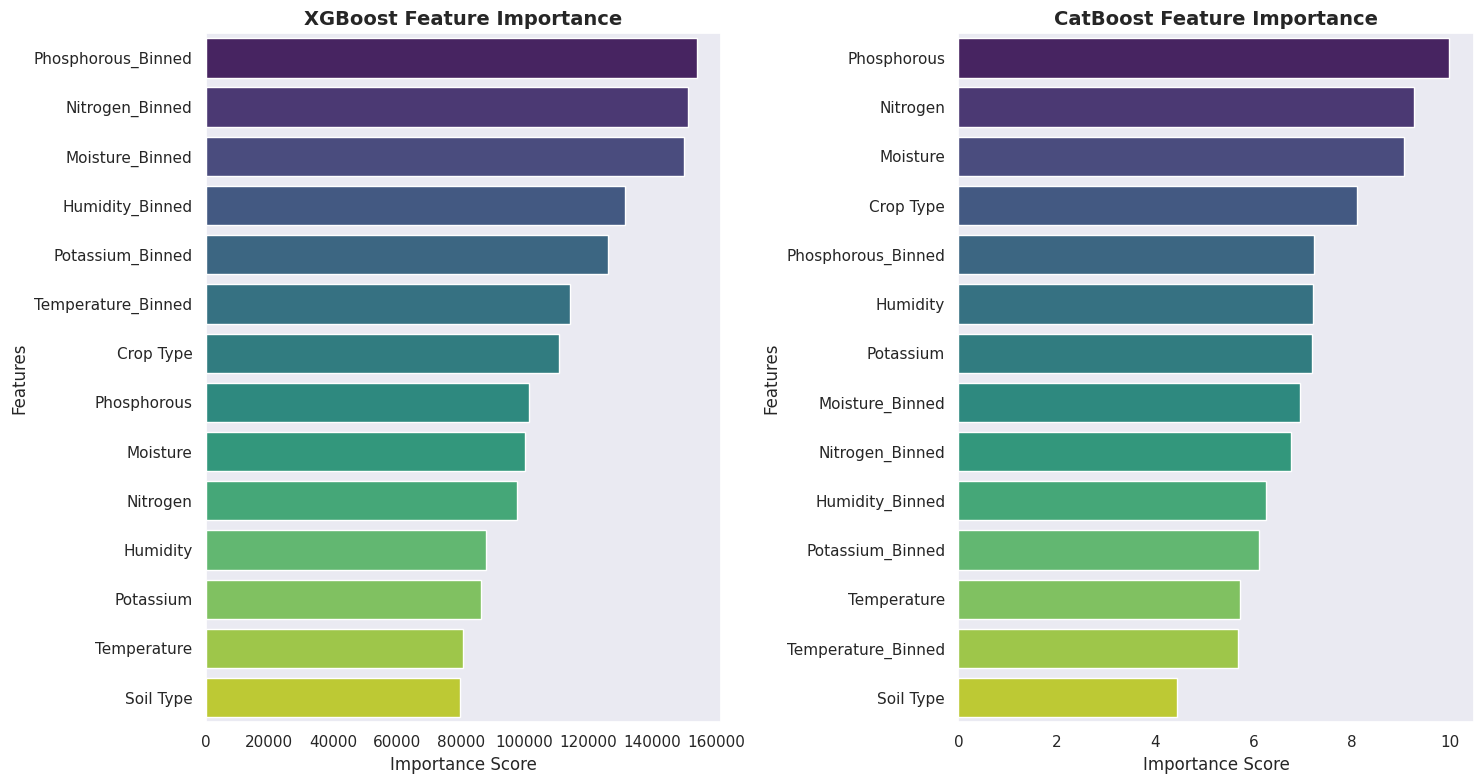

In [24]:
# Feature Importance Visualization
def plot_feature_importances(xgb_model, cb_model, feature_names, top_n=15):
    
    # XGBoost importance
    xgb_imp = xgb_model.get_score(importance_type='weight')
    xgb_df = pd.DataFrame({'feature': list(xgb_imp.keys()), 'importance': list(xgb_imp.values())})
    xgb_df = xgb_df.sort_values('importance', ascending=False).head(top_n)
    
    # CatBoost importance
    cb_imp = cb_model.get_feature_importance()
    cb_df = pd.DataFrame({'feature': feature_names, 'importance': cb_imp})
    cb_df = cb_df.sort_values('importance', ascending=False).head(top_n)

    fig, axes = plt.subplots(1, 2, figsize=(15, 8))

    sns.barplot(data=xgb_df, x='importance', y='feature', ax=axes[0], palette='viridis')
    axes[0].set_title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Importance Score')
    axes[0].set_ylabel('Features')
    
    sns.barplot(data=cb_df, x='importance', y='feature', ax=axes[1], palette='viridis')
    axes[1].set_title('CatBoost Feature Importance', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Importance Score')
    axes[1].set_ylabel('Features')

    plt.tight_layout()
    plt.show()

plot_feature_importances(xgb_model, cb_model, X.columns)

In [25]:
# Stacking Meta Model and Optuna Hyperparameter Optimization

meta_features = np.concatenate([oof_xgb, oof_cat], axis=1)
print(f"Meta features shape: {meta_features.shape}")
print(f"Classes: {y.nunique()}")

meta_test = np.concatenate([pred_prob_xgb, pred_prob_cat], axis=1)
print(f"Test meta features shape: {meta_test.shape}")

def meta_objective(trial):

    C = trial.suggest_float('C', 1e-4, 1e4, log=True)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    max_iter = trial.suggest_int('max_iter', 500, 4000)


    skf_meta = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    map3_scores = []
    
    for train_idx, valid_idx in skf_meta.split(meta_features, y):
        X_meta_train, X_meta_valid = meta_features[train_idx], meta_features[valid_idx]
        y_meta_train, y_meta_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        meta_model = LogisticRegression(
            class_weight=class_weight,
            max_iter=max_iter,
            random_state=42,
            C=C,
            n_jobs=-1
        )
        
        meta_model.fit(X_meta_train, y_meta_train)
        meta_preds_proba = meta_model.predict_proba(X_meta_valid)
        
        top_3_meta = np.argsort(meta_preds_proba, axis=1)[:, -3:][:, ::-1]
        actual = [[label] for label in y_meta_valid]
        map3_score = mapk(actual, top_3_meta)
        map3_scores.append(map3_score)
    
    return np.mean(map3_scores)

meta_study = optuna.create_study(direction="maximize")
meta_study.optimize(meta_objective, n_trials=30, show_progress_bar=True, gc_after_trial=True)

print(f"\n Best MAP@3: {meta_study.best_value:.5f}")

[I 2025-07-22 01:58:39,095] A new study created in memory with name: no-name-e95e80e9-25de-4507-b999-570cc66e9086


Meta features shape: (750000, 14)
Classes: 7
Test meta features shape: (250000, 14)


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-22 01:59:04,774] Trial 0 finished with value: 0.37365533333333334 and parameters: {'C': 0.005493658542562734, 'class_weight': 'balanced', 'max_iter': 3742}. Best is trial 0 with value: 0.37365533333333334.
[I 2025-07-22 02:00:13,136] Trial 1 finished with value: 0.37664155555555556 and parameters: {'C': 76.815950014429, 'class_weight': None, 'max_iter': 3783}. Best is trial 1 with value: 0.37664155555555556.
[I 2025-07-22 02:01:11,112] Trial 2 finished with value: 0.3766764444444445 and parameters: {'C': 8.736931085129902, 'class_weight': None, 'max_iter': 909}. Best is trial 2 with value: 0.3766764444444445.
[I 2025-07-22 02:02:11,442] Trial 3 finished with value: 0.3766833333333333 and parameters: {'C': 0.7568039686139829, 'class_weight': None, 'max_iter': 2099}. Best is trial 3 with value: 0.3766833333333333.
[I 2025-07-22 02:02:34,377] Trial 4 finished with value: 0.37388755555555553 and parameters: {'C': 0.008384100286782022, 'class_weight': 'balanced', 'max_iter': 1091

In [26]:
meta_study.best_params

{'C': 0.1791754897008912, 'class_weight': None, 'max_iter': 1731}

In [27]:
# Final model for stacking
best_meta_params = meta_study.best_params

best_meta_model = LogisticRegression(
    random_state=42,
)

best_meta_model.fit(meta_features, y)
meta_test_preds = best_meta_model.predict_proba(meta_test)

In [29]:
# Prepare submission

top_3_preds = np.argsort(meta_test_preds, axis=1)[:, -3:][:, ::-1]
top_3_labels = fer_label_enc.inverse_transform(top_3_preds.ravel()).reshape(top_3_preds.shape)

df_sub = pd.read_csv("/kaggle/input/playground-series-s5e6/sample_submission.csv")
submission = pd.DataFrame({
    'id': df_sub['id'],
    'Fertilizer Name': [' '.join(row) for row in top_3_labels]
})

submission.to_csv('submission_stacking.csv', index=False)
print("Submission file created: submission_stacking.csv")

Submission file created: submission_stacking.csv
